# CNN
1. 이미지 제너레이터 객체 생성
2. 객체.flow_from_directory( 경로, targetsize, batch, class . . )
3. 모델 구성
  Conv Pool Conv Conv Pool faltten Desne Dense
4. 모델 학습 (fit_generator())

In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import *
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
'data/dogcat/train'

In [5]:
# 쉬운 유지보수를 위한 상수정의 
## 데이터 형상 관련 상수
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

In [38]:
# 트레이닝 데이터 불러오기
filenames = os.listdir('data/dogcat/train')

In [33]:
import re

In [34]:
label = []
for i in filenames :
    if re.search('cat.+',i) :
        label.append(0)
    else :
        label.append(1)
        
df = pd.DataFrame({'filenames':filenames, 'label':label})
df

,filenames,label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


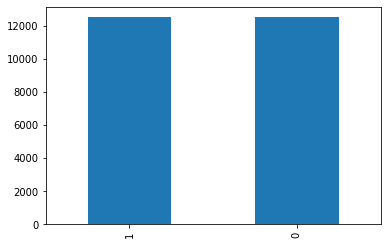

In [41]:
df['label'].value_counts().plot.bar()

Text(0.5, 1.0, 'dog.7993.jpg')

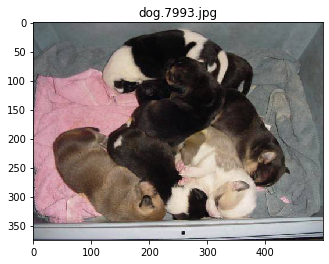

In [78]:
sample = random.choice(filenames)

image = load_img('data/dogcat/train/'+str(sample))

plt.imshow(image)
plt.title(sample)

In [ ]:
# 배치 정규화
# : 신경망에 입력 데이터를 평균=0 분산=1로 정규화를 해서 학습이 잘 이뤄지게 하는 것

In [79]:
from keras.models import Sequential
from keras.layers import *

In [84]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                 input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [86]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
# reducelronplateau
# : lss가 더이상 개선되지 않으면 lr을 감소시켜라

In [88]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [89]:
earlystop = EarlyStopping(patience=10)

In [91]:
learning_rate_reduction = ReduceLROnPlateau(
    patience=2, monitor='val_accuracy', factor=0.5, min_lr=0.00001, verbose=1
)

In [92]:
callbacks = [earlystop, learning_rate_reduction]

In [95]:
# 이미지제너레이터에서 class_mode='categorical'로 지정하기위해 컬럼값을 string으로 지정
df['label'] = df['label'].replace({0:'cat', 1:'dog'})

In [119]:
# 트레인 테스트 데이터 분리
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)


In [120]:
train_df.shape     # (20000, 2)
validate_df.shape  # (5000, 2)

(5000, 2)

In [121]:
# 뒤죽박죽 섞인 인덱스 초기화
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

cat    2515
dog    2485
Name: label, dtype: int64

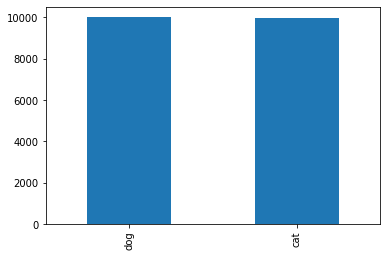

In [122]:
train_df['label'].value_counts().plot.bar()
validate_df['label'].value_counts()

In [123]:
# 데이터의 건수 추출
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [126]:
# 이미지 제너레이터 설정
train_datagen = ImageDataGenerator(
    rotation_range=15,      # 15도 범위 내에서 회전
    rescale=1./255,         # 정규화
    shear_range=0.1,
    zoom_range=0.2,         # +-20% 정도 확대 축소
    horizontal_flip=True,   # 수평방향으로 뒤짚음
    width_shift_range=0.1,  # 좌우로 10% 정도 움직임
    height_shift_range=0.1   
)

In [132]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='data/dogcat/train/',
    x_col='filenames',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [133]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory='data/dogcat/train/',
    x_col='filenames',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [182]:
# 랜덤으로 하나 추출
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filenames,label
0,dog.606.jpg,dog


In [183]:
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    directory='data/dogcat/train/',
    x_col='filenames',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


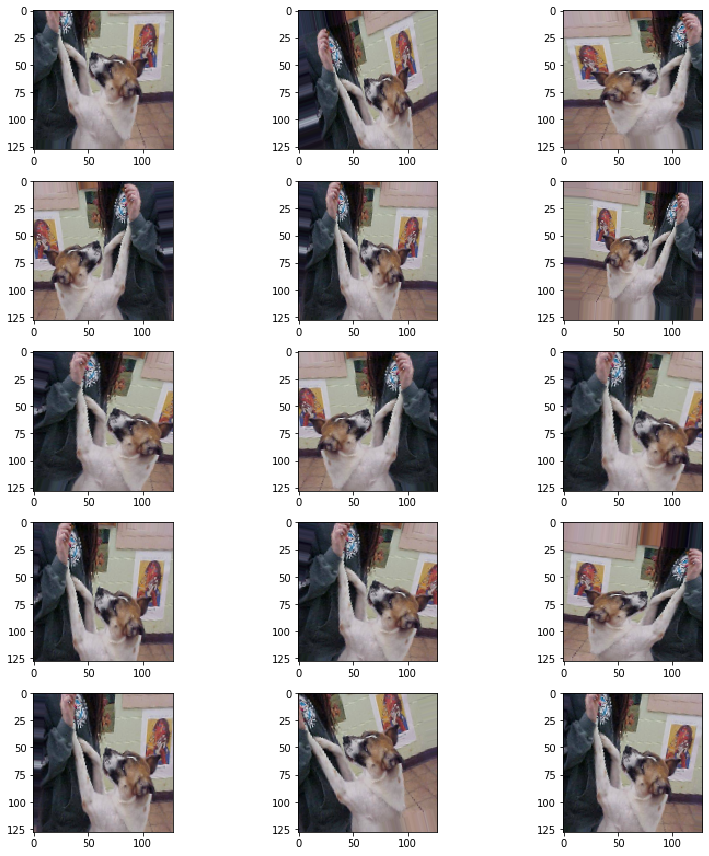

In [184]:
plt.figure(figsize=(12,12))
for i in range(15) :
    plt.subplot(5,3,i+1) # (5,3,1) .. (5,3,15)
    for xBatch, yBatch in example_generator :
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [187]:
FAST_RUN = True

epochs = 3 if FAST_RUN else 50

In [188]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=total_train//batch_size,
    validation_data=validation_generator,
    validation_steps=total_validate //batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 1066s 800ms/step - loss: 0.6941 - accuracy: 0.6470 - val_loss: 0.4830 - val_accuracy: 0.7047
Epoch 2/3
1333/1333 [==============================] - 1037s 778ms/step - loss: 0.5405 - accuracy: 0.7340 - val_loss: 0.8269 - val_accuracy: 0.7101
Epoch 3/3
1333/1333 [==============================] - 1114s 836ms/step - loss: 0.4984 - accuracy: 0.7642 - val_loss: 0.5908 - val_accuracy: 0.7944


In [189]:
model.save('mdoel.h5')

In [191]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

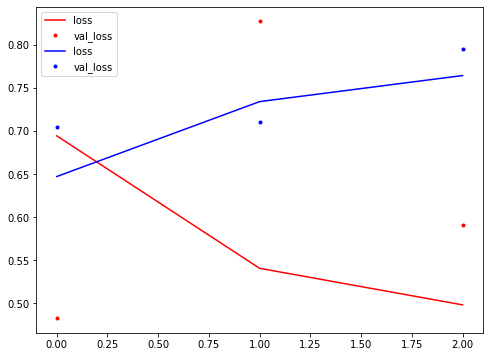

In [203]:
plt.figure(figsize=(8,6))
plt.plot(loss,'-r', label='loss')
plt.plot(val_loss, '.r', label='val_loss')

plt.plot(accuracy,'-b', label='loss')
plt.plot(val_accuracy, '.b', label='val_loss')

plt.legend()

In [210]:
testfile = os.listdir('data/dogcat/test')
testdf = pd.DataFrame({'filename':testfile})
testdf

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
...,...
12495,9995.jpg
12496,9996.jpg
12497,9997.jpg
12498,9998.jpg


In [220]:
nbsamples = testdf.shape[0]
nbsamples

12500

In [208]:
testGen = ImageDataGenerator(rescale=1./255)

In [214]:
testGenerator = testGen.flow_from_dataframe(
    testdf,
    directory='data/dogcat/test/',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size
                            )

Found 12500 validated image filenames.


In [223]:
predict = model.predict_generator(testGenerator, steps=nbsamples/batch_size)
predict

array([[0.11493669, 0.8850633 ],
       [0.8136259 , 0.18637416],
       [0.517383  , 0.48261696],
       ...,
       [0.03947929, 0.96052074],
       [0.9086874 , 0.09131252],
       [0.9579327 , 0.04206731]], dtype=float32)

In [225]:
predict_argmax = np.argmax(predict, 1)
predict_argmax

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [227]:
testdf['label'] = predict_argmax
testdf['label'].value_counts()

0    7004
1    5496
Name: label, dtype: int64

In [ ]:
testdf.to_csv

In [233]:
sub = pd.read_csv('data/dogcat/sampleSubmission.csv')
sub['label'] = predict_argmax
sub.to_csv('Submission.csv')

In [ ]:
'''
1. 시각화 
history.history['loss']
history.history['val_loss']
history.history['accuracy']
history.history['val_accuracy']

2. 테스트
data/dogcat/test/
testdf = {'filename' : 테스트 파일}

nbsamples = testdf.shape[0]

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='data/dogcat/test/',
    x_col='filenames',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size
)

3. 예측
predict = model.predict_generator(test_generator, step=nbsample/batch_size)

4. argmax
testdf['label'] = np.argmax(predict, axis=1)

5. 캐글 제출
'''


In [338]:
import keras
fm = keras.datasets.fashion_mnist
(trainImage, trainLabel),(testImage, testLabel) = fm.load_data()

# 레이블 : 0~9 (티셔츠, 신발, 가방 .. )

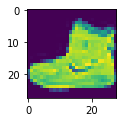

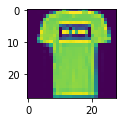

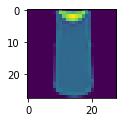

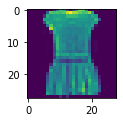

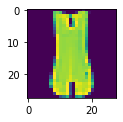

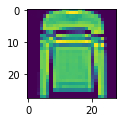

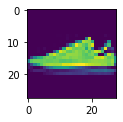

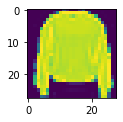

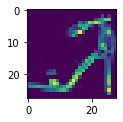

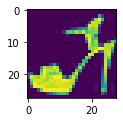

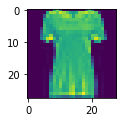

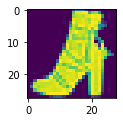

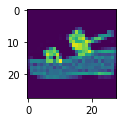

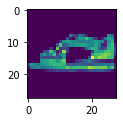

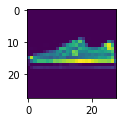

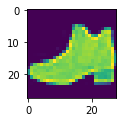

In [343]:
for i in range(16) : 
    plt.figure(figsize=(15,15))
    plt.subplot(2,8,i+1)
    
    plt.imshow(trainImage[i])

In [345]:
trainImage.shape  # (60000, 28, 28)
testImage.shape   # (10000, 28, 28)

trainImage = trainImage.reshape(trainImage.shape+(1,)).astype('float32') / 255
testImage = testImage.reshape(testImage.shape+(1,)).astype('float32') / 255
trainImage.shape

(60000, 28, 28, 1)

In [313]:
# 원핫인코딩
trainLabel = to_categorical(trainLabel)
testLabel = to_categorical(testLabel)

In [322]:
# 데이터나누기
trainImage, validImage, trainLabel, validLabel = train_test_split(trainImage, trainLabel, test_size=0.2, random_state=777)

In [ ]:
trainImage.shape
validImage.shape

In [315]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNEL = 1

In [330]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                 input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

In [331]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [332]:
model.fit(trainImage, trainLabel, epochs=15, batch_size=200, validation_data=(validImage, validLabel),
         callbacks=[earlystop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 69s 1ms/step - loss: 0.8717 - accuracy: 0.7046 - val_loss: 1.8748 - val_accuracy: 0.3842
Epoch 2/15
48000/48000 [==============================] - 64s 1ms/step - loss: 0.5501 - accuracy: 0.8011 - val_loss: 0.7331 - val_accuracy: 0.6885
Epoch 3/15
48000/48000 [==============================] - 72s 1ms/step - loss: 0.4706 - accuracy: 0.8293 - val_loss: 0.4014 - val_accuracy: 0.8470
Epoch 4/15
48000/48000 [==============================] - 73s 2ms/step - loss: 0.4331 - accuracy: 0.8421 - val_loss: 0.3553 - val_accuracy: 0.8641
Epoch 5/15
48000/48000 [==============================] - 73s 2ms/step - loss: 0.4023 - accuracy: 0.8509 - val_loss: 0.3865 - val_accuracy: 0.8600
Epoch 6/15
48000/48000 [==============================] - 78s 2ms/step - loss: 0.3877 - accuracy: 0.8583 - val_loss: 0.3428 - val_accuracy: 0.8720
Epoch 7/15
48000/48000 [==============================] - 86s 2ms/st

In [336]:
model.evaluate(testImage, testLabel)

10000/10000 [==============================] - 7s 674us/step


[0.3022571149587631, 0.8892999887466431]

In [ ]:
import tensorflow as tf
# tf.__version__
# '1.15.0'
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# Using TensorFlow backend.
path = r"Q:\이미지공유폴더0\\"
trainFileList = os.listdir(path+'train')
testFileList = os.listdir(path+'test')
trainFileList = [x for x in trainFileList if 'jpg' in x]
testFileList = [x for x in testFileList if 'jpg' in x]
word = {'ga' : 0, 'da' : 1, 'sa' : 2, 'aa' : 3, 'ka' : 4}
for i, file in enumerate(trainFileList):
    label, nm, tr, _ = file.split('_')
    code, ext = _.split('.')
        
    new_img = load_img(path+'train\\'+file)
    arr_img = img_to_array(new_img)
    img = arr_img.reshape((1,)+arr_img.shape)
    if i == 0 :
        container = img
        labels = word[label]
    else:
        container = np.vstack([container, img])
        labels = np.vstack([labels, word[label]])
​
xTrain = container
yTrain = np_utils.to_categorical(labels,5)       
​
for i, file in enumerate(testFileList):
    label, nm, tr, _ = file.split('_')
    code, ext = _.split('.')
        
    new_img = load_img(path+'test\\'+file)
    arr_img = img_to_array(new_img)
    img = arr_img.reshape((1,)+arr_img.shape)
    if i == 0 :
        container = img
        labels = word[label]
    else:
        container = np.vstack([container, img])
        labels = np.vstack([labels, word[label]])
        
xTest = container
yTest = np_utils.to_categorical(labels,5)   
print(container.shape, labels.shape)
print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)
(90, 28, 28, 3) (90, 1)
(180, 28, 28, 3) (180, 5)
(90, 28, 28, 3) (90, 5)
xTrain = xTrain.astype('float32')/255
xTest = xTest.astype('float32')/255
Keras CNN
from keras.layers import *
from sklearn.metrics import accuracy_score
# 모델 구성
​
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same',
                input_shape=(28,28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Conv2D(128, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(xTrain, yTrain, 
                    epochs=200, batch_size=30)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6242486871588896111
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1443813785
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2403246923327279918
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
result = model.predict_classes(xTest)
yTest.shape
answer = []
for i in yTest:
    answer.append(np.argmax(i))
yTest_label = []
for y in yTest:
    yTest_label.append(np.argmax(y))
accuracy_score(yTest_label, result)
0.8
Keras 이미지 증식
from keras.preprocessing.image import ImageDataGenerator
path = r"Q:\이미지공유폴더\\"
os.listdir(path+'train')
['aa', 'da', 'ga', 'ka', 'sa']
import shutil
​
trainFileList = [x for x in trainFileList if 'jpg' in x]
testFileList = [x for x in testFileList if 'jpg' in x]
# 폴더 만들어주기 train
currentPath = path + 'train'
print(word.keys())
try:
    for key in word.keys(): # ga da ...
        os.makedirs(currentPath + f'\\{key}')
except:
    pass
​
for file in trainFileList:
    label = file.split('_')[0]
    targetPath = currentPath + f'\\{label}'
    try :
        shutil.move(currentPath+f'\\{file}', targetPath+f'\\{file}')
    except:
        pass
dict_keys(['ga', 'da', 'sa', 'aa', 'ka'])
# 폴더 만들어주기 test
currentPath = path + 'test'
print(word.keys())
try:
    for key in word.keys(): # ga da ...
        os.makedirs(currentPath + f'\\{key}')
except:
    pass
​
for file in testFileList:
    label = file.split('_')[0]
    targetPath = currentPath + f'\\{label}'
    try :
        shutil.move(currentPath+f'\\{file}', targetPath+f'\\{file}')
    except:
        pass
dict_keys(['ga', 'da', 'sa', 'aa', 'ka'])
trainDataGen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest'
                                 )
trainGenSet = trainDataGen.flow_from_directory(
    path + 'train',
    batch_size=32,
    target_size=(28,28),
    class_mode='categorical'
)
Found 180 images belonging to 5 classes.
testDataGen = ImageDataGenerator(rescale=1./255,                                )
testGenSet = testDataGen.flow_from_directory(
    path + 'test',
    target_size=(28,28),
    batch_size=32,
    class_mode='categorical'
)
Found 90 images belonging to 5 classes.
# 모델 구성
# 기존 모델 형식 그대로 가져왔음
​
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(28,28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Conv2D(128, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
​
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.summary()
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_13 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               590080    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1285      
=================================================================
Total params: 962,181
Trainable params: 962,181
Non-trainable params: 0
_________________________________________________________________
#모델 학습 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_loss', patience=10)
# fig_generator
model.fit_generator(
    trainGenSet,
    steps_per_epoch=20,
    epochs=200,
#     validation_data=testGenSet,
#     validation_steps=10,
#     callbacks=[es] 
)
Epoch 199/200
20/20 [==============================] - 1s 42ms/step - loss: 0.1576 - accuracy: 0.9487
Epoch 200/200
20/20 [==============================] - 1s 51ms/step - loss: 0.0825 - accuracy: 0.9730
<keras.callbacks.callbacks.History at 0x21188b69788>
# result = model.predict_generator(testGenSet, steps=5)
scores = model.evaluate_generator(testGenSet)
print(scores)
[0.05801161751151085, 0.9777777791023254]
정확도 95.54%, max 정확도 : 99.35%

Keras 작성자 맞추기
path = r"Q:\이미지공유폴더2\\"
trainFileList = os.listdir(path+'train')
testFileList = os.listdir(path+'test')
trainFileList = [x for x in trainFileList if 'jpg' in x]
testFileList = [x for x in testFileList if 'jpg' in x]
trainFileList.sort(key=lambda x : int(x[-6:-4]))
label_list = list(set(map(lambda x : x[-6:-4], trainFileList)))
# 폴더 만들어주기 train
currentPath = path + 'train'
​
try:
    for key in label_list: # ga da ...
        os.makedirs(currentPath + f'\\{key}')
except:
    pass
​
for file in trainFileList:
    label = file.split('_')[3].split('.')[0]
    targetPath = currentPath + f'\\{label}'
    try :
        shutil.move(currentPath+f'\\{file}', targetPath+f'\\{file}')
    except:
        pass
# 폴더 만들어주기 train
currentPath = path + 'test'
​
try:
    for key in label_list: # ga da ...
        os.makedirs(currentPath + f'\\{key}')
except:
    pass
​
for file in testFileList:
    label = file.split('_')[3].split('.')[0]
    targetPath = currentPath + f'\\{label}'
    try :
        shutil.move(currentPath+f'\\{file}', targetPath+f'\\{file}')
    except:
        pass
trainDataGen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest'
                                 )
trainGenSet = trainDataGen.flow_from_directory(
    path + 'train',
    batch_size=64,
    target_size=(28,28),
    class_mode='categorical'
)
Found 180 images belonging to 18 classes.
testDataGen = ImageDataGenerator(rescale=1./255)
testGenSet = testDataGen.flow_from_directory(
    path + 'test',
    target_size=(28,28),
    batch_size=64,
    class_mode='categorical'
)
Found 90 images belonging to 18 classes.
valDataGen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 15,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.1,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest')
​
valGenSet = valDataGen.flow_from_directory(
    path + 'train',
    target_size=(28,28),
    batch_size=64,
    class_mode='categorical'
)
Found 180 images belonging to 18 classes.
# 모델 구성
​
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(28,28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
​
model.add(Conv2D(128, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
​
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
​
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.summary()
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_22 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               590080    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 18)                4626      
=================================================================
Total params: 965,522
Trainable params: 965,522
Non-trainable params: 0
_________________________________________________________________
#모델 학습 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_loss', patience=20)
# fig_generator
model.fit_generator(
    trainGenSet,
    steps_per_epoch=40,
    epochs=400,
    validation_data=valGenSet,
    validation_steps=20,
#     callbacks=[es] # 여긴 콜백 없나??
)
scores = model.evaluate_generator(testGenSet)
print(scores)
[4.4587812423706055, 0.644444465637207]

